# ECON 210C Homework 4

Written by: Jiahui Shui

## Problem 1 Code
We have two methods to handle this problem. The first method is to use the DAG provided by Professor Wieland. Solving the Jacobian will give us the IRF of $y$,$c$,$r$ and $i$. Actually, we have to take $n$ into account. This can be done from the equation
$$\hat{y}_t=\hat{a}_t+\hat{n}_t$$
Then we must have
$$\frac{\mathrm{d}\hat{y}_t}{\mathrm{d}\hat{a}_t}=1+\frac{\mathrm{d}\hat{n}_t}{\mathrm{d}\hat{a}_t}$$

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
## Parameters
beta = 0.99
sigma = 1
kappa = 0.1
rho = 0.8
phi_pi = 1.5
gamma = 1
varphi = 1

In [3]:
T = 50

In [4]:
I = sp.sparse.eye(T)
Ip1 = sp.sparse.diags([np.ones(T-1)], [1], (T, T))
Im1 = sp.sparse.diags([np.ones(T-1)], [-1], (T, T))
O = sp.sparse.csr_matrix((T, T))

In [5]:
## Euler Equation
Phieuy = gamma * I - gamma * Ip1
Phieuc = O
Phieur = O
Phieui = I

dHdY = sp.sparse.bmat([[Phieuy, Phieuc, Phieur, Phieui]])

Phieupi = -Ip1
Phieuy_flex = O
dHdU = sp.sparse.bmat([[Phieupi]])
dHdZ = sp.sparse.bmat([[Phieuy_flex]])

In [6]:
## NKPC and Central Bank
Phiy_yflex = I
Phic_yflex = I
Phir_yflex = O
Phii_yflex = O
Phiypi = 1/kappa*(I-beta*Ip1)
Phicpi = Phiypi
Phiipi = phi_pi*I
Phirpi = phi_pi*I-Ip1
dYdZ = sp.sparse.bmat([[Phiy_yflex], [Phic_yflex], [Phir_yflex], [Phii_yflex]])
dYdU = sp.sparse.bmat([[Phiypi], [Phicpi], [Phirpi], [Phiipi]])

In [7]:
dHdU.shape

(50, 50)

In [8]:
dHdU = dHdY @ dYdU + dHdU
dHdZ = dHdY @ dYdZ + dHdZ

In [9]:
dUdZ = -sp.sparse.linalg.spsolve(dHdU, dHdZ)
dYdZ = dYdU @ dUdZ + dYdZ
dXdZ = sp.sparse.bmat([[dUdZ],
                       [dYdZ]])

/Users/benshui/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/var/folders/48/1rvc22rd6jd0__b5ksw4k3340000gn/T/ipykernel_79092/3960164303.py:1: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  dUdZ = -sp.sparse.linalg.spsolve(dHdU, dHdZ)


In [10]:
a = np.zeros((T, 1))
a[0] = 1
for t in range(1, T):
    a[t] = rho * a[t-1]

In [11]:
X = dXdZ @ a
Phiyflex_a = (1+varphi)/(gamma+varphi)*I

In [12]:
pi = Phiyflex_a@X[0:T]
y = Phiyflex_a@X[T:2*T]
c = Phiyflex_a@X[2*T:3*T]
r = Phiyflex_a@X[3*T:4*T]
i = Phiyflex_a@X[4*T:5*T]

In [13]:
y_flex = Phiyflex_a@a
n = y-a

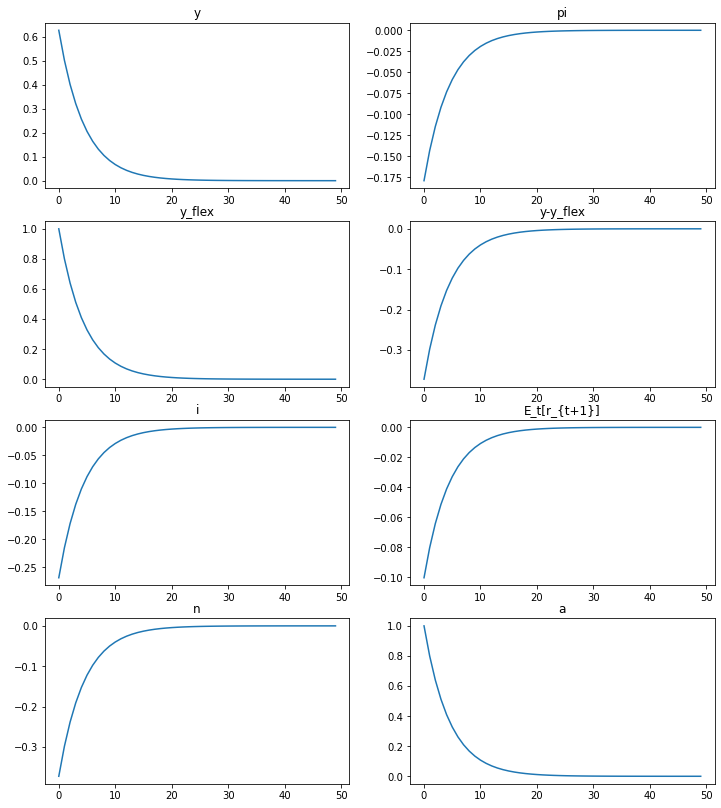

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(12, 14))
ax[0, 0].plot(y, label='y')
ax[0, 0].set_title('y')
ax[0, 1].plot(pi, label='pi')
ax[0, 1].set_title('pi')
ax[1, 0].plot(y_flex, label='y_flex')
ax[1, 0].set_title('y_flex')
ax[1, 1].plot(y-y_flex, label='y-y_flex')
ax[1, 1].set_title('y-y_flex')
ax[2, 0].plot(i, label='i')
ax[2, 0].set_title('i')
ax[2, 1].plot(Ip1@r, label='E_t[r_{t+1}]')
ax[2, 1].set_title('E_t[r_{t+1}]')
ax[3, 0].plot(n, label='n')
ax[3, 0].set_title('n')
ax[3, 1].plot(a, label='a')
ax[3, 1].set_title('a')
plt.savefig('sequence_space.png', dpi=300)

## Alternative Solution
Actually, we can achieve our goal in a much, much simplier way. Since we have already solved all variables as a function of $\hat{a}$, we can immediately obtain those irfs without solving sequence problem. 
We have
           $$\begin{equation}
           	\hat{r}_t=\hat{i}_t-\mathbb{E}_t[\hat{\pi}_{t+1}]=(\eta_{ia}-\rho_a\eta_{\pi a})\hat{a}_t
           \end{equation}$$
Hence
           $$\begin{equation}
           	\mathbb{E}_t[\hat{r}_{t+1}]=(\eta_{ia}-\rho_a\eta_{\pi a})\rho_a\hat{a}_t
           \end{equation}$$
Also
           $$\begin{equation}
           	   \hat{n}_t=\hat{y}_t-\hat{a}_t=(\eta_{ya}-1)\hat{a}_t
           \end{equation}$$

In [15]:
eta_ya = kappa * sigma * (phi_pi - rho) * (1+varphi) / ((1-rho)*(1-beta*rho)+kappa*sigma*(phi_pi-rho)) / (gamma+varphi)
eta_pia = -kappa * (1+varphi) * (1-rho) / ((1-rho)*(1-beta*rho)+kappa*sigma*(phi_pi-rho)) / (gamma+varphi)
eta_ia = phi_pi * eta_pia
eta_rprimea = (eta_ia - rho*eta_pia)*rho
eta_na = eta_ya - 1

In [16]:
y_flex = (1+varphi) / (gamma+varphi) * a
y = eta_ya * a
c = y
rprime = eta_rprimea * a
i = eta_ia * a
n = eta_na * a

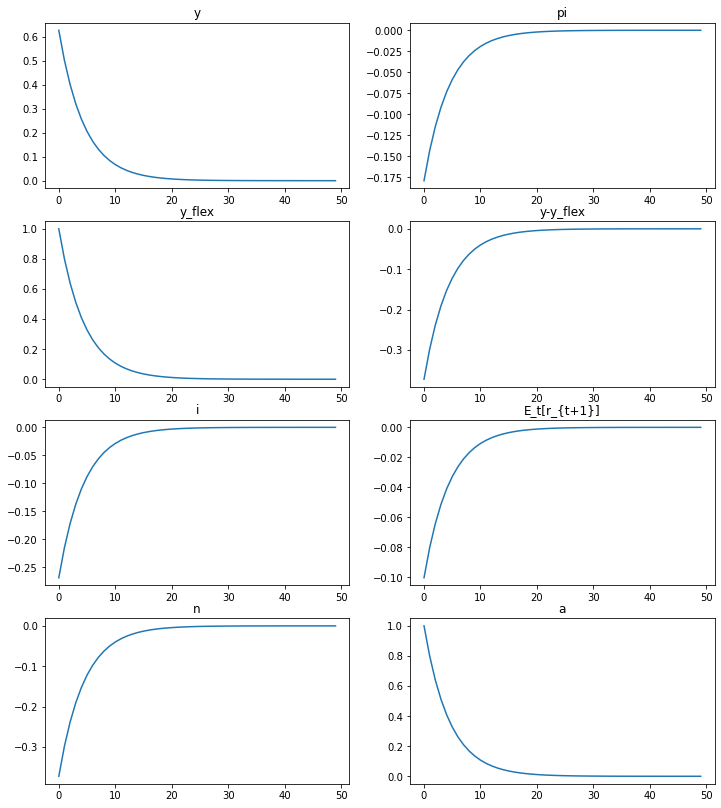

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(12, 14))
ax[0, 0].plot(y, label='y')
ax[0, 0].set_title('y')
ax[0, 1].plot(pi, label='pi')
ax[0, 1].set_title('pi')
ax[1, 0].plot(y_flex, label='y_flex')
ax[1, 0].set_title('y_flex')
ax[1, 1].plot(y-y_flex, label='y-y_flex')
ax[1, 1].set_title('y-y_flex')
ax[2, 0].plot(i, label='i')
ax[2, 0].set_title('i')
ax[2, 1].plot(rprime, label='E_t[r_{t+1}]')
ax[2, 1].set_title('E_t[r_{t+1}]')
ax[3, 0].plot(n, label='n')
ax[3, 0].set_title('n')
ax[3, 1].plot(a, label='a')
ax[3, 1].set_title('a')
plt.savefig('undertermined_parameters.png', dpi=300)